In [1]:
## If dataset folder is the same directory as the script in Google Colab
# from google.colab import drive
# drive.mount('/content/mydrive')
# path = '/content/mydrive/My Drive/Colab Notebooks/DL/HW6/Hw6_Q1_dataset/HW6_data/'

## Local Jupyter Notebook
path = '/Hw6_Q1_dataset/HW6_data/'

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [0]:
# This code is provided for Deep Learning class (CS 482/682) Homework 6 practice.
# This is a sketch code for main function. There are some given hyper-parameters insideself.
# You need to finish the design and train your network.
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
import os
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Q(a) and Q(b)
learning_rate = 0.01 ## Originally 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000

# Design your own dataloader
class ImageDataset(Dataset):
    def __init__(self, input_dir):
        self.path = input_dir

    def __len__ (self):
        folder_name = self.path.split('/')[-1]
        if folder_name == 'train':
            return 300
        else:
            return 50

    def __getitem__(self,idx):
        img_temp = str(idx) + "/" + str(idx) + "_input.jpg"
        img_path = os.path.join(self.path, img_temp)
        mask_temp = str(idx) + "/" + str(idx) + "_mask.png"
        mask_path = os.path.join(self.path, mask_temp)
        
        img = plt.imread(img_path)
        img = np.atleast_3d(img).transpose(2,0,1).astype(np.float32)
        img = torch.from_numpy(img).float()
        
        mask = plt.imread(mask_path)
        mask = (mask * 255).round().astype(np.uint8)
        mask = np.atleast_3d(mask).transpose(2,0,1).astype(np.float32)
        mask = torch.from_numpy(mask).float()
        oHot = mask == 0
        for i in range(1,8):
            oHot = torch.cat([oHot, mask == i*32])
            
        return img, oHot

train_dataset=ImageDataset(input_dir = path+'segmentation/train/')
validation_dataset=ImageDataset(input_dir = path+'segmentation/validation/' )
test_dataset=ImageDataset(input_dir = path+'segmentation/test/' )
train_loader = DataLoader(dataset=train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True);
validation_loader = DataLoader(dataset=validation_dataset,
                                          batch_size=validation_batch_size,
                                          shuffle=True);
test_loader = DataLoader(dataset=test_dataset,
                                          batch_size=validation_batch_size,
                                          shuffle=True);

In [0]:
# This code is provided for Deep Learning class (CS 482/682) Homework 6 practice.
# The network structure is a simplified U-net. You need to finish the last layers
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def add_merge_stage(ch_coarse, ch_fine, in_coarse, in_fine, upsample):
  conv = nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  torch.cat(conv, in_fine)

  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  )
  upsample(in_coarse)

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=True):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    ## weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    ## Design your last layer & activations
    self.conv_last = nn.Conv2d(32, 8, 1)


  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)

    ## Design your last layer & activations
    out = self.conv_last(conv1m_out)
    out = torch.sigmoid(out)

    return out


In [0]:
def dice_loss(output, labels):
  output = output.contiguous()
  labels = labels.contiguous()
  
  tp = (output*labels).sum(dim=2).sum(dim=2)
  tpfp = output.sum(dim=2).sum(dim=2)
  tpfn = labels.sum(dim=2).sum(dim=2)
  loss = (1 - ( (2.*tp + 1e-7) / (tpfp+tpfn+1e-7) ) )
  
  return loss.mean()

Training Started!

EPOCH 1 of 1000

Training Loss: 0.8814
1m 14s
Validation Loss: 0.8405
0m 38s

EPOCH 2 of 1000

Training Loss: 0.7534
2m 8s
Validation Loss: 0.6218
0m 35s

EPOCH 3 of 1000

Training Loss: 0.6710
1m 33s
Validation Loss: 0.6215
0m 35s

EPOCH 4 of 1000

Training Loss: 0.6714
1m 29s
Validation Loss: 0.6215
0m 36s

EPOCH 5 of 1000

Training Loss: 0.6568
1m 21s
Validation Loss: 0.6215
0m 36s

EPOCH 6 of 1000

Training Loss: 0.6707
1m 24s
Validation Loss: 0.6215
0m 53s

EPOCH 7 of 1000

Training Loss: 0.6683
1m 10s
Validation Loss: 0.6215
0m 36s

EPOCH 8 of 1000

Training Loss: 0.6424
1m 18s
Validation Loss: 0.6215
0m 36s

EPOCH 9 of 1000

Training Loss: 0.6827
1m 7s
Validation Loss: 0.6215
0m 36s

EPOCH 10 of 1000

Training Loss: 0.6560
1m 8s
Validation Loss: 0.6215
0m 48s

EPOCH 11 of 1000

Training Loss: 0.6848
2m 3s
Validation Loss: 0.6215
0m 59s

EPOCH 12 of 1000

Training Loss: 0.6541
1m 52s
Validation Loss: 0.6215
0m 52s

EPOCH 13 of 1000

Training Loss: 0.6697
1m 38s

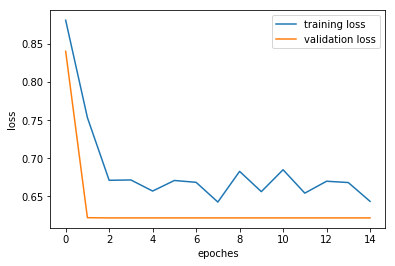

In [5]:
model = unet();

import time
import copy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Training Started!")
train_losses = []
val_losses = []
converge_epoch = []
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # Please design your own training section
    since = time.time()
    losses=[]
    for _, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels.float())

        ### Data Augmentation
        i_ver = copy.deepcopy(images)  ## image vertical flip
        i_hor = copy.deepcopy(images)  ## image horizontal flip
        v_ver = copy.deepcopy(labels)  ## labels vertical flip
        v_hor = copy.deepcopy(labels)  ## labels horizontal flip

        for i in range(train_batch_size):
            for p in range(3):
                i_ver[i][p] = torch.from_numpy(np.flipud(images[i][p]).copy())
                i_hor[i][p] = torch.from_numpy(np.fliplr(images[i][p]).copy())
            for q in range(8):
                v_ver[i][q] = torch.from_numpy(np.flipud(labels[i][q]).copy())
                v_hor[i][q] = torch.from_numpy(np.fliplr(labels[i][q]).copy())
        
        # Regular Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.item())
        
        # Vertical Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(i_ver)
        loss = dice_loss(outputs, v_ver)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.item())
        
        # Horizontal Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(i_hor)
        loss = dice_loss(outputs, v_hor)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.item())

        break
    ### Average Batch Loss
    mean_loss = sum(losses)/len(losses)
    print("Training Loss: %.4f" % (mean_loss))
    train_losses.append(mean_loss)
    converge_epoch.append(epoch)
    
    ### Timing
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    ########################### Validation #####################################
    # Please design your own validation section
    model.eval()
    since = time.time()
    losses=[]

    for (images, labels) in validation_loader:
        images = Variable(images.float())
        labels = Variable(labels.float())

        outputs = model(images)
        loss = dice_loss(outputs, labels)
        losses.append(loss.data.item())
    
    ### Average Batch Loss
    mean_loss = sum(losses)/len(losses)
    print("Validation Loss: %.4f" % (mean_loss))
    val_losses.append(mean_loss)
    
    ### Timing
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Early Stopping
    if epoch > 13 and abs(mean_loss - val_losses[epoch-1]) <= 0.001:
        print('The validation loss converges')
        break
plt.plot(converge_epoch, train_losses, label = "training loss")
plt.plot(converge_epoch, val_losses, label = "validation loss")
plt.xlabel('epoches')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
plt.plot(converge_epoch, train_losses, label = "training loss")
plt.plot(converge_epoch, val_losses, label = "validation loss")
plt.xlabel('epoches')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: ignored

In [6]:
########################### Testing #####################################
# Please design your own validation section
model.eval()
since = time.time()
losses=[]

for (images, labels) in test_loader:
    images = Variable(images.float())
    labels = Variable(labels.float())

    outputs = model(images)
    loss = dice_loss(outputs, labels)
    losses.append(loss.data.item())

### Average Batch Loss
mean_loss = sum(losses)/len(losses)
print("Testing performance - DICE score: %.4f" % (1-mean_loss))

### Timing
time_elapsed = time.time() - since
print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Testing performance - DICE score: 0.3584
1m 3s
